In [1]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# input img -> hidden dim -> mean, std -> parametrization -> decoder -> output img
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20):
        super().__init__()
        out_dim = (input_dim ** 0.5 - 8) ** 2 
        
        # encoder
        self.img2h = nn.Linear(input_dim, h_dim)
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z2h = nn.Linear(z_dim, h_dim)
        self.h2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.Tanh()
    
    def encode(self, x):
        h = self.relu(self.img2h(x))
        mu, sigma = self.h2mu(h), self.h2sigma(h)

        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z2h(z))
        img = torch.sigmoid(self.h2img(h))

        return img

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma * epsilon #
        x_reconstructed = self.decode(z_reparametrized)

        return x_reconstructed, mu, sigma

In [3]:
# config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = 32*32 * 3
h_dim = 200
z_dim = 48
num_epochs = 10
batch_size = 32
lr = 3e-4

train = True
PATH = 'models/cifar_vae_athome.pth'

In [4]:
# load mnist dataset
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [5]:
features, labels = next(iter(train_loader))
features.shape

torch.Size([32, 1, 28, 28])

In [6]:
# load cifar10 dataset
cifar_dataset = datasets.CIFAR10(root='cifar_dataset', train=True, transform=transforms.ToTensor(), download=True)
cifar_loader = DataLoader(dataset=cifar_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [7]:
transform = transforms.Compose([
    transforms.Resize(size=(32,32)),
    transforms.ToTensor(),
])

# load celeba dataset
celeba_dataset = datasets.CelebA(root='cifar_dataset', transform=transform, download=True)
celeba_loader = DataLoader(dataset=celeba_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified


In [8]:
features, labels = next(iter(cifar_loader))
features.shape

torch.Size([32, 3, 32, 32])

In [9]:
# init model
model = VariationalAutoEncoder(input_dim, h_dim, z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss(reduction='sum')

In [10]:
train = False
PATH = 'models/cifar_vae_athome.pth'

if train:
    # start training
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(celeba_loader))

        for i, (x, _) in loop:
            # forward pass
            x = x.to(device).view(x.shape[0], input_dim)
            x_reconstructed, mu, sigma = model(x)

            # compute loss
            reconstruction_loss = loss_fn(x_reconstructed, x)
            kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            # back prop
            loss = reconstruction_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

else:
    model.load_state_dict(torch.load(PATH))

In [11]:
# saves the model
PATH = 'models/cifar_vae_athome.pth'
#torch.save(model.state_dict(), PATH)

In [12]:
# mnist inference
def inference(digit, num_examples=1):
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for ex in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon #
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        out = out.detach().numpy()
        plt.figure()
        plt.imshow(out[0,0,::])
        #plt.figure()
        #plt.imshow(images[digit].view(28,28))
        #save_image(out, f"generated_{digit}_ex{ex}.png")

torch.Size([1, 28, 28])
torch.Size([3, 32, 32])


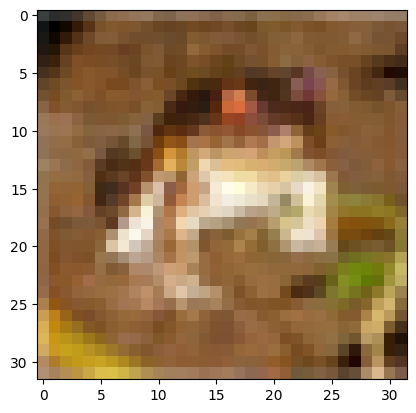

In [13]:
print(dataset[1][0].shape)
print(cifar_dataset[1][0].shape)

plt.figure()
plt.imshow(cifar_dataset[0][0].detach().numpy().transpose(1,2,0))

In [14]:
cifar_labels = {0:'airplane',
                1:'automobile',
                2:'bird',
                3:'cat',
                4:'deer',
                5:'dog',
                6:'frog',
                7:'horse',
                8:'ship',
                9:'truck'}

# cifar inference
def cifar_inference(digit, num_examples=1):
    image = []
    for i, (x, y) in enumerate(cifar_dataset):
        if y == digit:
            image.append(x.view(1, input_dim))
            break

    mu, sigma = model.encode(image[0])

    res = []
    for ex in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon #
        out = model.decode(z)
        out = out.view(3, 32, 32)
        out = out.detach().numpy().transpose(1,2,0)
        res.append(out)

    return res

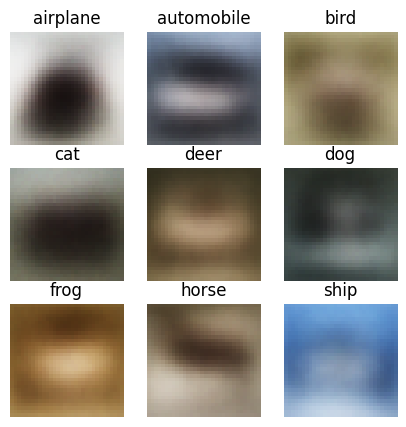

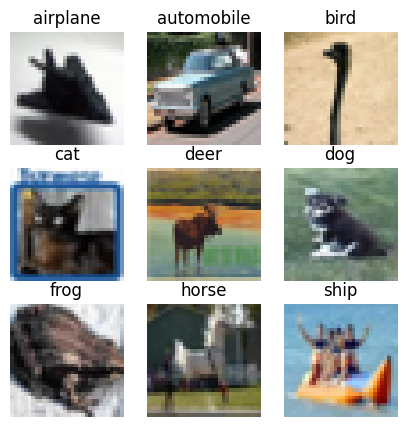

In [15]:
model = model.to("cpu")

# shows reconstructed samples
fig1 = plt.figure(figsize=(5, 5))
cols, rows = 3, 3

for idx in range(1, cols * rows + 1):
    img = cifar_inference(idx-1, num_examples=1)
    fig1.add_subplot(rows, cols, idx)
    plt.title(cifar_labels[idx-1])
    plt.axis("off")
    plt.imshow(img[0])


# shows original samples
fig2 = plt.figure(figsize=(5,5))

idx = 0
for i, (x, y) in enumerate(cifar_dataset):
    if y == idx:
        img = x.detach().numpy().transpose(1,2,0)
        fig2.add_subplot(rows, cols, idx+1)
        plt.title(cifar_labels[idx])
        plt.axis("off")
        plt.imshow(img)
        idx += 1
    if idx == 9:
        break

In [16]:
model2 = VariationalAutoEncoder(input_dim, h_dim, z_dim).to(device)

train = False
PATH = 'models/celeba_vae_athome.pth'

if train:
    # start training
    for epoch in range(num_epochs):
        loop = tqdm(enumerate(celeba_loader))

        for i, (x, _) in loop:
            # forward pass
            x = x.to(device).view(x.shape[0], input_dim)
            x_reconstructed, mu, sigma = model2(x)

            # compute loss
            reconstruction_loss = loss_fn(x_reconstructed, x)
            kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            # back prop
            loss = reconstruction_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())

else:
    model2.load_state_dict(torch.load(PATH))

In [17]:
# saves the model
PATH = 'models/celeba_vae_athome.pth'
#torch.save(model.state_dict(), PATH)

In [18]:
# celeba inference
def celeba_inference(digit, num_examples=1):
    image = []
    for i, (x, y) in enumerate(celeba_dataset):
        image.append(x.view(1, input_dim))
        break

    mu, sigma = model2.encode(image[0])

    res = []
    for ex in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon #
        out = model2.decode(z)
        out = out.view(3, 32, 32)
        out = out.detach().numpy().transpose(1,2,0)
        res.append(out)

    return res

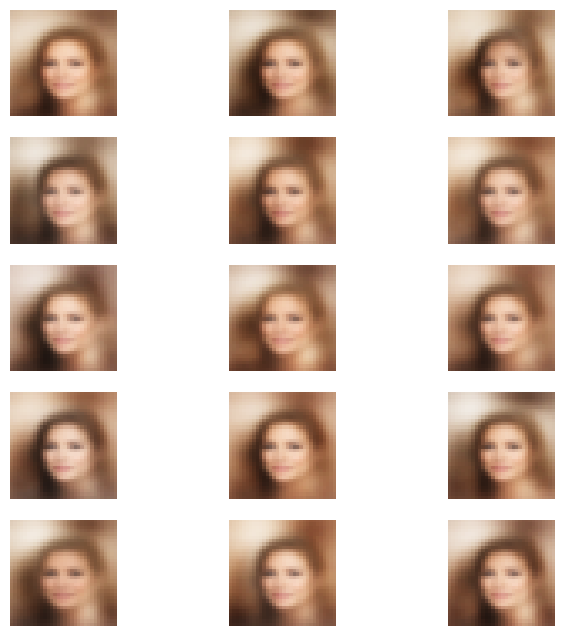

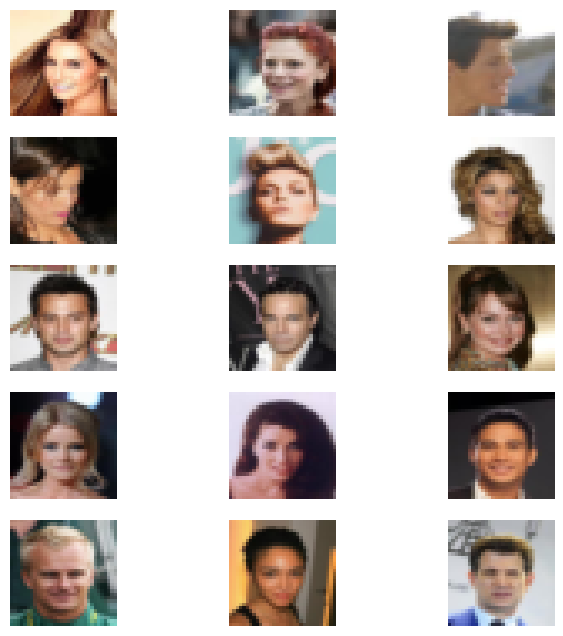

In [19]:
model2 = model2.to("cpu")

# shows reconstructed samples
fig1 = plt.figure(figsize=(8, 8))
cols, rows = 3, 5
results = []

for idx in range(1, cols * rows + 1):
    img = celeba_inference(idx-1, num_examples=1)
    results.append(img[0])
    fig1.add_subplot(rows, cols, idx)
    plt.axis("off")
    plt.imshow(img[0])


# shows original samples
fig2 = plt.figure(figsize=(8,8))

idx = 0
for i, (x, y) in enumerate(celeba_dataset):
    img = x.detach().numpy().transpose(1,2,0)
    fig2.add_subplot(rows, cols, idx+1)
    plt.axis("off")
    plt.imshow(img)
    idx += 1

    if idx == 15:
        break

In [20]:
# Code derived from tensorflow/tensorflow/models/image/imagenet/classify_image.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path
import sys
import tarfile

import numpy as np
import urllib
import tensorflow as tf
import glob
import scipy.misc
import math
import sys

In [21]:
MODEL_DIR = 'models/inception/'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None

In [22]:
# Call this function with list of images. Each of elements should be a 
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 1
  with tf.compat.v1.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  print(filepath)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.compat.v1.gfile.GFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

  # Works with an arbitrary minibatch size.
  with tf.compat.v1.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')#
    print(pool3)
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            #print(o)
            #shape = [s.value for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o.set_shape(tf.TensorShape(new_shape))
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3, [1, 2]), w)
    softmax = tf.nn.softmax(logits)

if softmax is None:
  _init_inception()

models/inception/inception-2015-12-05.tgz
Tensor("pool_3:0", shape=(1, 1, 1, 2048), dtype=float32)


In [23]:
num_per_label = 40
results = []

for idx in range(1, 10 + 1):
    img = cifar_inference(idx-1, num_examples=num_per_label)
    for i in img:
        results.append(i)

processed_res = [x*255 for x in results]
print('Cifar10 images inception score:')
get_inception_score(processed_res)

Cifar10 images inception score:
................................................................................................................................................................................................................................................................................................................................................................................................................

(1.2531623, 0.07472739)

In [24]:
num_per_label = 40
results = []

for idx in range(1, 10 + 1):
    img = celeba_inference(idx-1, num_examples=num_per_label)
    for i in img:
        results.append(i)

processed_res = [x*255 for x in results]
print('CelebA images inception score:')
get_inception_score(processed_res)

CelebA images inception score:
................................................................................................................................................................................................................................................................................................................................................................................................................

(1.1213919, 0.01881719)